# Exp012: Train classifiers from corpus examples
This experiments uses regular expressions to identify possible positive and hard negative instances in multiple corpora. It may add handpicked generated examples if the corpus does not have enough examples.

In [23]:
import os
from dotenv import load_dotenv
load_dotenv()
os.environ['CACHE_DIR'] = f"/scratch/tmp.{os.getenv('SLURM_JOB_ID')}.dglandorf" # speed up model loading

import re
import os
import random
import numpy as np
from torch import tensor, Tensor
from torch.nn import DataParallel
from torch.utils.data import DataLoader, TensorDataset, random_split, Subset
from sklearn.model_selection import KFold
from collections import defaultdict
from tqdm import tqdm
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.ticker import FuncFormatter

import sys
sys.path.append('../source')
import models
import data
import importlib
importlib.reload(data)

[nltk_data] Downloading package punkt to
[nltk_data]     /scratch/tmp.55650421.dglandorf...
[nltk_data]   Package punkt is already up-to-date!


<module 'data' from '/cluster/home/dglandorf/grammarctg/experiments/../source/data.py'>

In [3]:
# load corpus sentences and prepare dataloader
sentences = data.get_mixed_sentences(1000000) # get all sentences

# initialize corpus to check against
max_batches = 64
batch_size = 256
encoded_inputs = models.bert_tokenizer(sentences[:12*max_batches*batch_size], return_tensors='pt', max_length=64, padding='max_length', truncation=True)
encoded_inputs['sentences'] = sentences[:12*max_batches*batch_size]
corpus_dataset = TensorDataset(encoded_inputs['input_ids'], encoded_inputs['attention_mask'])
corpus_dataloader = DataLoader(corpus_dataset, batch_size=batch_size, shuffle=False)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:23<00:00,  5.86s/it]


In [6]:
# output dataset
output_path = '../data/annotated_corpus.json'
instances = pd.DataFrame(columns=['#', 'sentence', 'positive']) if not os.path.exists(output_path) else pd.read_json(output_path)
instances['positive'] = instances['positive'].astype(bool)

egp_gpt = pd.read_json("../data/egp_gpt35.json")

In [5]:
# manipulation functions for instance dataset
def get_positives(instances, nr):
    return list(instances[(instances['#'] == nr) & instances['positive']]['sentence'])
def get_negatives(instances, nr):
    return list(instances[(instances['#'] == nr) & ~instances['positive']]['sentence'])
def get_others(sentences, matches):
    return list(set(sentences).difference(set(matches)))
def add_to_instances(sentences, nr, positive=True):
    global instances
    if isinstance(sentences, list):
        for sentence in sentences:
            new_row = pd.DataFrame({'#': [nr], 'sentence': [sentence], 'positive': [positive]})
            instances = pd.concat([instances, new_row], ignore_index=True)
    else:
        new_row = pd.DataFrame({'#': [nr], 'sentence': [sentences], 'positive': [positive]})
        instances = pd.concat([instances, new_row], ignore_index=True)
    instances.to_json(output_path)

# model training
def get_trained_classifer(positive, negative, others, classifier=models.RuleDetector(models.bert_encoder).to(models.device), ratio=1, verbose=True):
    dataset = data.get_dataset(positive, negative, others, models.bert_tokenizer, 64, ratio*len(positive)/len(negative), verbose=verbose) 
    train_dataloader, val_dataloader = data.get_loaders(dataset)
    _, val_metrics = models.train(classifier, train_dataloader, val_dataloader, num_epochs=None, verbose=verbose)
    return classifier, val_metrics

Find examples for would rules (616-638), superlatives (1105-1131), negations (1175-1205)

In [6]:
nr = 1186

In [7]:
pattern = r"don't"
matches = [sentence for sentence in sentences if re.search(pattern, sentence, re.IGNORECASE)]
random.shuffle(matches)
candidates = iter(matches)

In [53]:
gpt35 = egp_gpt[egp_gpt['#']==nr].iloc[0]
egp_matches = gpt35['augmented_examples']
random.shuffle(egp_matches)
candidates = iter(egp_matches)

In [140]:
anti_pattern =  r" most "
anti_matches = [sentence for sentence in sentences if re.search(anti_pattern, sentence, re.IGNORECASE)]
random.shuffle(anti_matches)
candidates = iter(anti_matches)

In [43]:
candidates = iter(subset_sentences)

In [30]:
candidates = iter(get_positives(instances, nr))

In [48]:
while 1==1:
    if len(get_positives(instances, nr)) == 50: print("** REACHED 50 POSITIVES **")
    try:
        candidate = next(candidates)
    except StopIteration:
        print("No candidates left.")
        break
    if candidate in list(instances[instances['#'] == nr]['sentence']): continue # prevent duplicates
    #candidate = candidate.replace(",", "")
    user_response = input(f"{candidate}")
    if user_response == "c": break
    if user_response == "s": continue
    if user_response == "del": 
        instances = instances.iloc[:-1]
        continue
    new_row = pd.DataFrame({'#': [nr], 'sentence': [candidate], 'positive': [True if user_response == '2' else False]})
    instances = pd.concat([instances, new_row], ignore_index=True)
    instances.to_json(output_path)

Do sit down, won't you? 1
Why don't you just stick a gun in my ribs and take everything I have? 1
Haven't you heard that today men are becoming increasingly interested in having their eyebrows professionally groomed? 1
I don't know if I told you or not, but I decided to start my own business. 2
But aren't you afraid of over-working yourself? 1
Why don't you turn off the TV and get outside? 1
I don't think we will be able to pay the price. 2
why don't you try? 1
I'm sorry I don't know how to pronounce that. 2
Why don't you come out and play with us? 1
Well, I could put you on a waiting list.But that doesn't guarantee you will get into the class. 1
It may take less time, but I don't know about easier. 1
Why don't we stop and have a rest here? 1
Believe it or not, tests don't mean that we should do extra work. 1
I just didn't feel that they were ready to open yet. 2
I don't believe it.He is only being with the company for two years. 1
I don't think it's there. 2
I don't think there's one 

In [36]:
#instances = instances.iloc[:-1]

In [8]:
get_positives(instances, nr)

["When I got out of the plane, I couldn't believe how cold it was.",
 "I don't think you're telling me the truth.",
 "I don't think they should be penalized for hard work.",
 "Well, I sympathize with your problem, but frankly, I don't think there is anything anyone can do for you.",
 "I didn't think I should ask LOL  Usually pageants are focused on judging and ranking the physical attributes of the contestants.",
 "We were thinking of going to the beach, but I don't think Martin is well enough to go.",
 "I don't think I could just eat vegetables, I would be missing out on so much.",
 "I can't believe its earliest use is traced back to Mexico in 1900 BCE.",
 "You transcript indicate that your English background is strong, so I don't think you have any problem with it.",
 "I can't believe Mr. Fro didn't buy it.",
 "Oh, I don't think I'll need to.",
 "I don't think mine were some fancy breed like that.",
 "I can't believe you actually found an apartment in the ads.",
 "I couldn't believe 

In [49]:
print(f'Positive: {len(get_positives(instances, nr))}, Negative: {len(get_negatives(instances, nr))}')

Positive: 185, Negative: 138


In [15]:
classifier, val_metrics = get_trained_classifer(get_positives(instances, nr), get_negatives(instances, nr), get_others(sentences, matches), ratio=3)
val_metrics

0.21070615034168566


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████| 22/22 [00:01<00:00, 18.95it/s]


Training loss: 0.16960221969268538
Val loss: 0.12551718267301717


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████| 22/22 [00:01<00:00, 20.71it/s]


Training loss: 0.1596404698423364
Val loss: 0.11424376939733823


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████| 22/22 [00:01<00:00, 20.63it/s]


Training loss: 0.1611937778917226
Val loss: 0.11424371475974719


{'accuracy': 0.977, 'f1': 0.944, 'precision': 0.919}

Check on entire corpus

In [16]:
# shuffle inputs
shuffled_index = np.random.permutation(encoded_inputs['input_ids'].size(0))
for key, value in encoded_inputs.items():
    encoded_inputs[key] = value[shuffled_index] if isinstance(value, Tensor) else [value[i] for i in shuffled_index]
classifier = DataParallel(classifier)
batch_size = 256
corpus_dataset = TensorDataset(encoded_inputs['input_ids'], encoded_inputs['attention_mask'])
corpus_dataloader = DataLoader(corpus_dataset, batch_size=batch_size, shuffle=False)
scores, tokens = models.score_corpus(classifier, corpus_dataloader, max_positive=200, max_batches=16000//batch_size, threshold=0.5)
results = list(zip(scores, tokens, encoded_inputs['sentences'][:len(scores)]))

  8%|████████▎                                                                                              | 62/768 [00:13<02:35,  4.53it/s]


In [17]:
threshold = 0.5

subset = [(score, token, sample) for score, token, sample in results if
     score > threshold and not sample in get_positives(instances, nr)]
subset_sentences = [sample for _, _, sample in subset]
candidates = iter(subset_sentences) 
subset_sentences

["I can't believe it!",
 "I don't think that I ever heard of that rule before.",
 "I didn't know what they're called in English.",
 "I didn't think this course would be so stressful.",
 "I don't know how.",
 "I don't think it's the best style for me.",
 "I can't tell whether he's serious or not so I need your advice.",
 "I don't even know how to use Facebook!",
 "I really don't know what to buy.",
 "You are still student so I don't think you should have time for that.",
 "I didn't realize it was a romance novel.",
 "I don't think I could stand being away from people for so long.",
 "I just don't think the salaries are comparable when you leave a major corporation.",
 "No, I don't think it's good for farming.",
 "Yes, but I don't know what soup you have.",
 "Unfortunately, I don't think it will be in the near future.",
 "I don't know what's the matter with it.",
 "But I don't think he's old enough to ride a bike to school.",
 "I just don't know what to do first.",
 "No, I didn't know I 

In [93]:
#add_to_instances(gpt35['augmented_examples'][100:150], nr, True)
#add_to_instances(random.sample(subset_sentences, 25), nr, False)
#add_to_instances(subset_sentences, nr, False)
#add_to_instances(random.sample(get_positives(instances, 619), 50), nr, False)
#add_to_instances(list(set(get_positives(instances, 621)).difference(get_negatives(instances, nr))), nr, False)
classifier, metrics = get_trained_classifer(get_positives(instances, nr), get_negatives(instances, nr), get_others(sentences, matches), ratio=2)
metrics

0.2


100%|██████████████████████████████████| 4/4 [00:00<00:00, 11.04it/s]


Training loss: 0.1677892841398716
Val loss: 0.1551961898803711


100%|██████████████████████████████████| 4/4 [00:00<00:00, 11.76it/s]


Training loss: 0.13315736316144466
Val loss: 0.09557819366455078


100%|██████████████████████████████████| 4/4 [00:00<00:00, 11.81it/s]


Training loss: 0.10834173485636711
Val loss: 0.08680586516857147


100%|██████████████████████████████████| 4/4 [00:00<00:00, 11.80it/s]


Training loss: 0.10036502685397863
Val loss: 0.08982415497303009


{'accuracy': 1.0, 'f1': 1.0, 'precision': 1.0}

In [19]:
models.save_classifier(classifier, nr, "corpus_training")

In [21]:
#nr=619
classifier = models.load_classifier(nr, "corpus_training")

In [22]:
 gpt35['Example']

"But I don't think it'll help you. \n\nI don't think I'll live here forever because I intend to move to Curitiba, a southern city of my country. \n\nI don't believe that the suitcase will be returned to me."

In [57]:
candidates = gpt35['Example'].split("\n\n") + ["I don't believe we have more of them.", "I don't believe."]
models.probe_model(classifier, candidates)

(tensor([0.9360, 0.9691, 0.9789, 0.9903, 0.0572]), ['t', 't', 't', 't', 't'])

In [171]:
candidates = ["I have by far the fastest car.", "He was by far the furthest singer of all time.", "It's the biggest content.", "I haven't the lushest clue."]
models.probe_model(classifier, candidates)

(tensor([0.7212, 0.9803, 0.0136, 0.0130]),
 ['fastest', '##thest', 'biggest', '##est'])

## Evaluation
Strategy: Track F1 score on validation set and precision in novel corpora sentences

In [3]:
existing_nrs = [int(name.replace(".pth","")) for name in os.listdir(f"../models/corpus_training")]
egp = data.get_egp()

In [4]:
total_folds = 5
batch_size = 32
metrics = {}

for nr in existing_nrs:
    print(f'#{nr}')
    pos = get_positives(instances, nr)
    neg = get_negatives(instances, nr)
    dataset = data.get_dataset(pos, neg, get_others(sentences, pos), models.bert_tokenizer, 64, 3*len(pos)/len(neg))
    indices = list(range(len(dataset)))
    kf = KFold(n_splits=total_folds, shuffle=True, random_state=26)
    accumulated_metrics = defaultdict(list)
    for fold_index in tqdm(range(total_folds)):
        train_indices, val_indices = list(kf.split(indices))[fold_index]
        train_dataloader = DataLoader(Subset(dataset, train_indices), batch_size=batch_size, shuffle=True)
        val_dataloader = DataLoader(Subset(dataset, val_indices), batch_size=batch_size, shuffle=False)
    
        classifier=models.RuleDetector(models.bert_encoder).to(models.device)
        _, val_metrics = models.train(classifier, train_dataloader, val_dataloader, verbose=False)
        if val_metrics['f1'] < 0.8: # try again in those extreme cases
            _, val_metrics = models.train(classifier, train_dataloader, val_dataloader, verbose=False)
        for metric_name, metric_value in val_metrics.items():
            accumulated_metrics[metric_name].append(metric_value)
    
    average_metrics = {metric_name: sum(metric_values) / len(metric_values) for metric_name, metric_values in accumulated_metrics.items()}
    metrics[nr] = average_metrics
    print(average_metrics)

#616


NameError: name 'get_positives' is not defined

In [27]:
metrics = {}

def get_gpt_positives(nr):
    gpt35 = egp_gpt[egp_gpt['#']==nr].iloc[0]
    return list(gpt35['augmented_examples'])

def get_gpt_negatives(nr):
    gpt35 = egp_gpt[egp_gpt['#']==nr].iloc[0]
    return list(gpt35['augmented_negative_examples'])

def get_gpt_others(nr):
    gpt35 = egp_gpt[egp_gpt['#']!=nr]
    return sum(gpt35['augmented_examples'], [])

for nr in existing_nrs:
    print(f'#{nr}')
    classifier, val_metrics = get_trained_classifer(get_gpt_positives(nr), get_gpt_negatives(nr), get_gpt_others(nr), ratio=5)
    while val_metrics['f1'] < 0.8:
        classifier, val_metrics = get_trained_classifer(get_gpt_positives(nr), get_gpt_negatives(nr), get_gpt_others(nr), ratio=5)
    
    metrics[nr] = {"pos_acc": (models.probe_model(classifier, get_positives(instances, nr))[0]>0.5).sum().item() / len(get_positives(instances, nr)),
                   "neg_acc": (models.probe_model(classifier, get_negatives(instances, nr))[0]<0.5).sum().item() / len(get_negatives(instances, nr))}
    print(metrics[nr])

#616
575
275
701381
2843
0.14305364511691884


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████| 91/91 [00:04<00:00, 20.10it/s]


Training loss: 0.07613955701158924
Val loss: 0.047365678150368774


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████| 91/91 [00:05<00:00, 16.90it/s]


Training loss: 0.0329165346600668
Val loss: 0.041794310273278665


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████| 91/91 [00:05<00:00, 15.24it/s]


Training loss: 0.03049788258683223
Val loss: 0.03864016349467894
{'pos_acc': 0.8085106382978723, 'neg_acc': 0.8682170542635659}
#617
528
253
701428
2640
0.15136403637430332


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████| 86/86 [00:04<00:00, 19.08it/s]


Training loss: 0.025204328641779666
Val loss: 0.020811447445091537


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████| 86/86 [00:05<00:00, 15.14it/s]


Training loss: 0.016184155285415284
Val loss: 0.019150716409058077
{'pos_acc': 0.9578947368421052, 'neg_acc': 0.625}
#618
625
275
701331
3022
0.13428120063191154


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████| 95/95 [00:05<00:00, 18.05it/s]


Training loss: 0.014911200134864838
Val loss: 0.003222363655368099


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████| 95/95 [00:06<00:00, 14.72it/s]


Training loss: 0.01113037212631561
Val loss: 0.001417744435154115
{'pos_acc': 0.36607142857142855, 'neg_acc': 0.928}
#619
575
285
701381
2723
0.14753631444033039


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████| 88/88 [00:04<00:00, 18.41it/s]


Training loss: 0.14302738810014984
Val loss: 0.08103928846751594


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████| 88/88 [00:05<00:00, 14.75it/s]


Training loss: 0.07723053928268862
Val loss: 0.06279544117437168


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████| 88/88 [00:05<00:00, 14.67it/s]


Training loss: 0.06715443278318906
Val loss: 0.059793020259927616
{'pos_acc': 0.4675324675324675, 'neg_acc': 0.6333333333333333}
#620
525
275
701431
2586
0.14944924084548972


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████| 84/84 [00:04<00:00, 18.12it/s]


Training loss: 0.1011502081112537
Val loss: 0.03447822927098189


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████| 84/84 [00:05<00:00, 14.77it/s]


Training loss: 0.030137148615072613
Val loss: 0.01934209817721109


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████| 84/84 [00:05<00:00, 14.46it/s]


Training loss: 0.019774651800010663
Val loss: 0.014626726005060067
{'pos_acc': 0.6875, 'neg_acc': 0.9442622950819672}
#621
700
275
701256
3296
0.12546125461254612


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 102/102 [00:05<00:00, 17.60it/s]


Training loss: 0.028437627674600875
Val loss: 0.009403933537914081


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 102/102 [00:06<00:00, 14.75it/s]


Training loss: 0.012275151058037961
Val loss: 0.01078717465650068
{'pos_acc': 0.9818181818181818, 'neg_acc': 0.6477272727272727}
#622
575
275
701381
2739
0.1442828628457371


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████| 88/88 [00:04<00:00, 18.05it/s]


Training loss: 0.29145124392446387
Val loss: 0.1085832199208777


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████| 88/88 [00:05<00:00, 14.73it/s]


Training loss: 0.06761244739093607
Val loss: 0.0722989414617504


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████| 88/88 [00:05<00:00, 14.67it/s]


Training loss: 0.044788096821534396
Val loss: 0.06082085687243803


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████| 88/88 [00:06<00:00, 14.40it/s]


Training loss: 0.03901512030411554
Val loss: 0.05763332938923585
{'pos_acc': 0.5098039215686274, 'neg_acc': 0.9227373068432672}
#623
525
275
701431
2586
0.14894250819183796


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████| 84/84 [00:04<00:00, 17.91it/s]


Training loss: 0.03715207322689128
Val loss: 0.017190919989453896


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████| 84/84 [00:05<00:00, 14.77it/s]


Training loss: 0.012787882792985155
Val loss: 0.005718056805476192


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████| 84/84 [00:05<00:00, 14.47it/s]


Training loss: 0.007446882026367045
Val loss: 0.003994643266889311
{'pos_acc': 0.85, 'neg_acc': 0.5}
#624
550
275
701406
2680
0.1472374891524443


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████| 87/87 [00:04<00:00, 17.61it/s]


Training loss: 0.129067447514209
Val loss: 0.04451346638697115


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████| 87/87 [00:05<00:00, 14.72it/s]


Training loss: 0.04644022907141125
Val loss: 0.03795989848863841


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████| 87/87 [00:05<00:00, 14.67it/s]


Training loss: 0.03937568664135968
Val loss: 0.035457977710228246
{'pos_acc': 0.6379310344827587, 'neg_acc': 0.7532467532467533}
#625
555
255
701401
2775
0.1455160744500846


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████| 89/89 [00:05<00:00, 17.42it/s]


Training loss: 0.12017778288625348
Val loss: 0.04832944488051631


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████| 89/89 [00:06<00:00, 14.63it/s]


Training loss: 0.03419762686303074
Val loss: 0.03441010242322986


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████| 89/89 [00:06<00:00, 14.51it/s]


Training loss: 0.022210826437064877
Val loss: 0.03233669852488674
{'pos_acc': 0.625, 'neg_acc': 0.9375}
#626
575
275
701381
2812
0.14226057906458797


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████| 90/90 [00:05<00:00, 17.48it/s]


Training loss: 0.059316538715372895
Val loss: 0.02022860129363835


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████| 90/90 [00:06<00:00, 14.70it/s]


Training loss: 0.022826558110278308
Val loss: 0.012485786768830503


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████| 90/90 [00:06<00:00, 14.45it/s]


Training loss: 0.016539512991926762
Val loss: 0.013069693390128163
{'pos_acc': 0.7666666666666667, 'neg_acc': 0.9016393442622951}
#627
525
260
701431
2614
0.15150620200826934


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████| 85/85 [00:04<00:00, 17.70it/s]


Training loss: 0.027253049578704284
Val loss: 0.009595682022081255


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████| 85/85 [00:05<00:00, 14.79it/s]


Training loss: 0.009150182646065813
Val loss: 0.007687308021682846
{'pos_acc': 0.8545454545454545, 'neg_acc': 0.8978102189781022}
#628
575
274
701381
2759
0.14415179835740582


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████| 89/89 [00:04<00:00, 17.89it/s]


Training loss: 0.3365487368545872
Val loss: 0.09624115417650699


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████| 89/89 [00:05<00:00, 14.87it/s]


Training loss: 0.08017321735008337
Val loss: 0.082859272521961


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████| 89/89 [00:06<00:00, 14.64it/s]


Training loss: 0.07891817458413458
Val loss: 0.07997715041932205
{'pos_acc': 0.6991869918699187, 'neg_acc': 0.8336633663366336}
#629
525
278
701431
2124
0.17981843575418993


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████| 72/72 [00:03<00:00, 18.16it/s]


Training loss: 0.15880536528149808
Val loss: 0.0476710786525574


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████| 72/72 [00:04<00:00, 14.74it/s]


Training loss: 0.03412270085472199
Val loss: 0.03589960138520433


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████| 72/72 [00:04<00:00, 14.70it/s]


Training loss: 0.02822122205139345
Val loss: 0.026508860716906685


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████| 72/72 [00:04<00:00, 14.70it/s]


Training loss: 0.02171002460494896
Val loss: 0.021574083967910457
{'pos_acc': 0.9431818181818182, 'neg_acc': 0.8991228070175439}
#637
500
250
701456
2500
0.15384615384615385


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████| 82/82 [00:04<00:00, 17.74it/s]


Training loss: 0.08705103018735649
Val loss: 0.025115619369205974


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████| 82/82 [00:05<00:00, 14.85it/s]


Training loss: 0.03249140805564821
Val loss: 0.021600013432492102
{'pos_acc': 0.9375, 'neg_acc': 0.6451612903225806}
#638
500
275
701456
2336
0.1616553507921112


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████| 78/78 [00:04<00:00, 18.15it/s]


Training loss: 0.08793478001816532
Val loss: 0.05820125774480402


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████| 78/78 [00:05<00:00, 14.82it/s]


Training loss: 0.06549139658156304
Val loss: 0.07107275892049074
{'pos_acc': 0.6, 'neg_acc': 0.7204724409448819}
#630
525
255
701431
2625
0.1536879224213929


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████| 86/86 [00:04<00:00, 18.27it/s]


Training loss: 0.12364764856457167
Val loss: 0.02334729632341557


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████| 86/86 [00:05<00:00, 15.02it/s]


Training loss: 0.03300752096719259
Val loss: 0.016247888360257177


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████| 86/86 [00:05<00:00, 14.85it/s]


Training loss: 0.022848761269880585
Val loss: 0.012123696409451606
{'pos_acc': 0.9770992366412213, 'neg_acc': 0.933649289099526}
#631
575
275
701381
2843
0.14328932893289328


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████| 91/91 [00:05<00:00, 17.76it/s]


Training loss: 0.160511611592393
Val loss: 0.0360495584267799


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████| 91/91 [00:06<00:00, 15.08it/s]


Training loss: 0.03423018335073081
Val loss: 0.014013738406862578


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████| 91/91 [00:06<00:00, 14.75it/s]


Training loss: 0.02447278482409624
Val loss: 0.011507036204895248
{'pos_acc': 1.0, 'neg_acc': 0.7411764705882353}
#632
500
274
701456


KeyboardInterrupt: 

In [12]:
metrics

{616: {'accuracy': 0.994, 'f1': 0.991, 'precision': 0.982},
 617: {'accuracy': 0.994, 'f1': 0.99, 'precision': 0.981},
 618: {'accuracy': 1.0, 'f1': 1.0, 'precision': 1.0},
 619: {'accuracy': 0.987, 'f1': 0.979, 'precision': 1.0},
 620: {'accuracy': 0.968, 'f1': 0.95, 'precision': 0.906},
 621: {'accuracy': 1.0, 'f1': 1.0, 'precision': 1.0},
 622: {'accuracy': 1.0, 'f1': 1.0, 'precision': 1.0},
 623: {'accuracy': 1.0, 'f1': 1.0, 'precision': 1.0},
 624: {'accuracy': 0.994, 'f1': 0.99, 'precision': 0.99},
 625: {'accuracy': 1.0, 'f1': 1.0, 'precision': 1.0},
 626: {'accuracy': 1.0, 'f1': 1.0, 'precision': 1.0},
 627: {'accuracy': 1.0, 'f1': 1.0, 'precision': 1.0},
 628: {'accuracy': 0.984, 'f1': 0.974, 'precision': 0.949},
 629: {'accuracy': 0.994, 'f1': 0.991, 'precision': 0.981},
 637: {'accuracy': 0.994, 'f1': 0.99, 'precision': 0.981},
 638: {'accuracy': 0.971, 'f1': 0.958, 'precision': 0.919},
 630: {'accuracy': 1.0, 'f1': 1.0, 'precision': 1.0},
 631: {'accuracy': 1.0, 'f1': 1.0, 

In [28]:
# check on examples
for nr in existing_nrs:
    classifier = models.load_classifier(nr, "corpus_training")
    rule = egp[egp['#']==nr].iloc[0]
    examples = rule['Example'].split("\n\n")
    print(rule['Can-do statement'])
    print(((models.probe_model(classifier, examples)[0]>0.5).sum()/len(examples)).item())

Can use the affirmative form with 'like'. 
1.0
Can use 'would like to invite' to make invitations.
1.0
Can use 'would like' to talk about wishes and preferences.
1.0
Can use the affirmative form.
1.0
Can use the negative forms.
1.0
Can use the question form 'would you like'.
1.0
Can use 'would' to talk about imagined situations.
0.5
Can use 'it would be' to make suggestions.
0.3333333432674408
Can use 'would' with a wide range of verbs to talk about wishes and preferences.
1.0
Can use 'would' in the main clause of a conditional sentence to talk about an imagined situation, often in the context of advice or opinion-giving.
1.0
Can use 'would have' + '-ed'.
1.0
Can use 'would not have' + '-ed' or 'wouldn’t have' + '-ed'
1.0
Can use question forms.
0.75
Can use an limited range of adverbs with 'would', including 'really', 'probably', 'certainly', 'definitely'.► adverbs
1.0
Can use an increasing range of adverbs with 'would', including 'strongly', 'easily', 'especially', 'actually', 'absol

In [29]:
tc = data.TextCorpora(['brown', 'reuters'])
dc = data.CMUDoG()
threshold=0.5
test_sentences = tc.get_all_sentences() + dc.get_all_sentences()
random.shuffle(test_sentences)
max_batches = 500
batch_size = 64
test_inputs = models.bert_tokenizer(test_sentences[:max_batches*batch_size], return_tensors='pt', max_length=64, padding='max_length', truncation=True)
test_dataset = TensorDataset(test_inputs['input_ids'], test_inputs['attention_mask'])
test_dataloader = DataLoader(test_dataset, batch_size=64, shuffle=False)

[nltk_data] Downloading package brown to
[nltk_data]     /scratch/tmp.55650421.dglandorf...
[nltk_data]   Unzipping corpora/brown.zip.
[nltk_data] Downloading package reuters to
[nltk_data]     /scratch/tmp.55650421.dglandorf...


In [30]:
hits_path = '../data/corpus_validation_hits.json'
coded_instances = pd.DataFrame(columns=['#', 'sentence', 'correct', 'score', 'max_token']) if not os.path.exists(hits_path) else pd.read_json(hits_path)
coded_instances['correct'] = coded_instances['correct'].astype(bool)
#coded_instances = coded_instances[coded_instances['#']!=622]

for nr in existing_nrs:
    rule = egp[egp['#']==nr].iloc[0]
    if len(coded_instances[coded_instances['#']==nr]) >= 10: continue
    print(f"#{nr}: {rule['Type']}: {rule['Can-do statement']} ({rule['SuperCategory']}: {rule['SubCategory']})")
    print(rule['Example'])
    classifier = models.load_classifier(nr, "corpus_training")
    classifier = DataParallel(classifier)

    scores, tokens = models.score_corpus(classifier, test_dataloader, max_positive=25, max_batches=max_batches, threshold=threshold)
    hits = [(score, token, sample) for score, token, sample in zip(scores, tokens, test_sentences[:len(scores)]) if score > threshold]
    for score, token, sample in hits[:20]:
        if sample in list(coded_instances[coded_instances['#']==nr]['sentence']): continue
        user_response = input(f"{sample}")
        new_row = pd.DataFrame({'#': [nr],
             'sentence': [sample],
             'correct': [user_response == '2'],
             'score': [score],
             'max_token': [token]})
        coded_instances = pd.concat([coded_instances, new_row], ignore_index=True)
        coded_instances.to_json(hits_path)

#617: USE: Can use 'would like to invite' to make invitations. (MODALITY: would)
I would like to invite you to dinner in my house on Saturday at 7 30 pm. 

Dear Neighbours, I would like to invite you to my home for dinner.


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [00:39<00:00, 12.70it/s]


#623: USE: Can use 'it would be' to make suggestions. (MODALITY: would)
[talking about a jazz concert] It would be very good if you came with me. 

It would be nice to bring your new computer game and some clothes. 

It would be perfect if you arrived at 7.20.


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [00:54<00:00,  9.18it/s]


It would be interesting to watch the film 2
That would be nice! 1
That would be an interesting role for him. 1
it would be a good book if it was from one 1
Herrington said that before he disclosed what recommendations for tax benefits for the oil and gas industry he might make , he would raise the matter with the White House Economic Policy Committee to see if the proposals to increase oil production made good tax policy . 1
Would it be helpful to be a Marvel fan before seeing this? 1
That would be great! 1


#638: FORM: Can use a wide range of adverbs with 'would', including 'undoubtedly', 'possibly', 'normally', 'personally', 'eventually', 'obviously', 'significantly', 'inevitably'. ► adverbs (MODALITY: would)
[talking about the construction of a leisure centre] I believe that the construction of such a centre would undoubtedly contribute to the improvement of our quality of life. 

Organising family-oriented activities would significantly increase membership and raise the society's popularity with the local community.


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [00:47<00:00, 10.43it/s]


With a Democratic administration , party patronage would normally begin to flow to Mississippi if it had held its Democratic solidarity in the November election . 2
It is estimated that about 542,250 miles of forest development roads , and 80,000 miles of trails , constitute the system that will eventually be needed to obtain the maximum practicable yield and use of the wood , water , forage , and wildlife and recreation resources of the National Forests on a continuing basis . 1
Thus the government simultaneously undertook the vast burden of social security which had traditionally been privately discharged , and created a national scarcity which has engendered calamitous problems of social security . 1
True, stefan has a lot of influence on her...otherwise she wouldn't of turned the moors into a dark kingdom 1
I suppose the day will inevitably come when the area will be encrusted with developments , but at present it is deserted and seductive . 1
He should personally consider the pote

#633: USE: Can use 'would' to make polite requests, often in the fixed expression 'would you mind'. (MODALITY: would)
Would you tell me about your room in your next letter, please? 

Would it be possible for you to meet me later that day, around 7? 

I had forgotten I have an appointment with my dentist at that time, so, would you mind if we met at 5 o'clock instead of meeting at 4 o'clock? 

We are supposed to have a barbecue for lunch, would you mind bringing a salad?


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [00:43<00:00, 11.51it/s]


Would you say there was a lot of story ? 1
Now... would you say it’s better than the Dark Knight? 1
would you agree? 1
Would you say this is your most favorite Christopher Nolan film? 1
Would you consider watching it again? 1
Would you watch it again? 1
Would the driver see the turtle ? ? 1
would you say that set the tone for the movie? 1


#635: USE: Can use the negative forms of 'would' to talk about willingness in the past. (MODALITY: would)
We had to leave without you because the bus driver wouldn't wait. 

[talking about a guitar] It was all that I wanted in life but my parents would not allow me to buy it.


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [00:50<00:00,  9.81it/s]


I remember him getting the dog, and the other toes being worried about that, but I think the dog wouldn't replace the toys so much as maybe destroy them ha ha 2
They wouldn't go hungry , not yet . 2
Once he had abandoned himself to the very worst , once he had quieted all the dragons of worry and suspense , there wouldn't be very much for Mae to do . 1
He would not comment on the new offer . 2
In addition , he said , he has answered more than 400 messages of congratulations which led him to the comment that he himself had decided he wouldn't send another congratulatory message for the rest of his life . 2
Wasn't it the mayor in Jaws that didn't want to "scare" people so he wouldn't cancel the holiday festivities! 2
But Myra wouldn't budge without an express invitation . 2
The halt , the first national strike by seamen in 25 years , started on February 27 , and union leaders said they would not return to work unless they got a 275 pct pay rise . 2
He knew it was there , knew also what i

#1105: FORM: Can form conditional subordinate clause with 'if' + present simple. (CLAUSES: conditional)
It is 3 hours long, and if you want to pass it you will have to study very hard, it is very difficult. 

If you buy a gift for me, please buy a book, because I love to read. 

If you agree, we can go shopping after the film.


  7%|███████                                                                                                | 34/500 [00:02<00:33, 13.88it/s]


If you watch the DVD, I believe they even have bloopers/behind-the-scenes from the movie at the end. 2
If he does, it is not portrayed in the movie directly. 2
" Revlon stands to make a substantial amount of money if someone else takes over Gillette ," said Analyst Deepak Raj of Merrill Lynch and Co . " I ' m not saying that is going to happen but Gillette is an undervalued stock with a breakup value of 45 dlrs per share ." 2
If you don't, then I wouldn't recommend it. 2
We cannot consider ourselves educated if we do not read ; ; 2
What was his role in Catch Me If You Can? 1
If you are interested in action thrillers of a man wronged trying to seek vengeance. 1
Have you seen Catch Me If You Can that stars Leonardo DiCaprio as Frank Abagnale, Jr.? 1
If I know that their work is usually phenomenal and a particular movie has awful ratings, I usually will wait to hear from friends/family before paying to see it. c


KeyboardInterrupt: Interrupted by user

In [11]:
hits_path = '../data/corpus_validation_hits.json'
coded_instances = pd.read_json(hits_path)
coded_instances['correct'] = coded_instances['correct'].astype(bool)

In [4]:
import json
metrics_path = "../results/corpus_training_metrics.json"

In [2]:

with open(metrics_path, 'w') as f:
    json.dump(metrics, f)

NameError: name 'metrics' is not defined

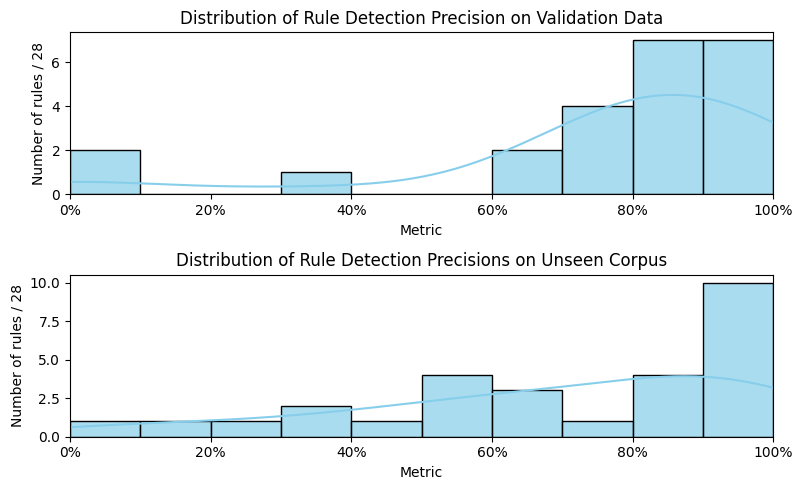

In [12]:
with open(metrics_path, 'r') as f:
    metrics = json.load(f)
correct_per_rule = coded_instances.groupby('#')['correct'].mean()
def plot_histogram(ax, data):
    sns.histplot(ax=ax, data=data, bins=10, kde=True, color="skyblue", edgecolor='black', alpha=0.7, legend=False)
    ax.set_ylabel(f"Number of rules / {len(correct_per_rule)}")
    ax.set_xlabel("Metric")
    ax.xaxis.set_major_formatter(FuncFormatter(lambda x, _: f'{x*100:.0f}%'))
    ax.set_xlim(0, 1)

fig, axs = plt.subplots(2, 1, figsize=(8, 5))
plot_histogram(axs[0], [m['precision'] for m in metrics.values()])
axs[0].set_title("Distribution of Rule Detection Precision on Validation Data")
plot_histogram(axs[1], list(correct_per_rule))
axs[1].set_title("Distribution of Rule Detection Precisions on Unseen Corpus")
plt.tight_layout()
plt.show()

In [19]:
corpus_instances = [np.mean([m['precision'] for m in metrics.values()]), correct_per_rule.mean()]

In [20]:
corpus_instances

[0.7550173913043479, 0.6870175146490934]

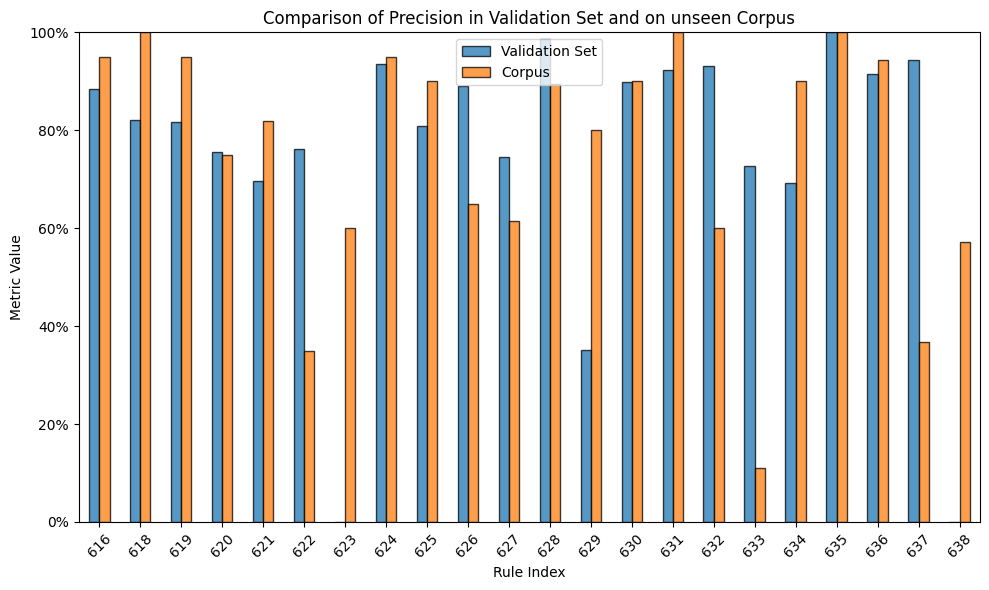

In [78]:
df = pd.DataFrame({'Validation Set': [m['precision'] for m in metrics.values()], 'Corpus': list(correct_per_rule)})
ax = df.plot(kind='bar', figsize=(10, 6), alpha=0.75, edgecolor='black')
ax.set_xlabel("Rule Index")
ax.set_ylabel("Metric Value")
ax.set_title("Comparison of Precision in Validation Set and on unseen Corpus")
ax.set_xticklabels(correct_per_rule.index, rotation=45)
ax.set_ylim(0, 1)
ax.yaxis.set_major_formatter(FuncFormatter(lambda y, _: f'{y*100:.0f}%'))

plt.tight_layout()
plt.show()